# Monte Carlo Methods

Here we do not assume complete knowledge of the environment. Monte Carlo methods require only experience—sample sequences of states, actions, and rewards from actual or simulated interaction with an environment.

Monte Carlo methods are ways of solving the reinforcement learning problem based on averaging sample returns. To ensure that well-defined returns are available, here we define Monte Carlo methods only for episodic tasks. That is, we assume experience is divided into episodes, and that all episodes eventually terminate no matter what actions are selected. 


## Monte Carlo Prediction for Blackjack

We begin by considering Monte Carlo methods for learning the state-value function for a given policy. Recall that the value of a state is the expected return—expected cumulative future discounted reward—starting from that state. An obvious way to
estimate it from experience, then, is simply to average the returns observed after visits to that state. As more returns are observed, the average should converge to the expected value. This idea underlies all Monte Carlo methods.

**First-visit:**<br>
The first-visit MC method estimates _vπ(s)_ as the average of the returns following first visits to _s_

<img src="src/first_visit_algorithm.png" width="700px">

## Implementation

### Imports

In [1]:
%matplotlib inline

import gym
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import sys

from collections import defaultdict

matplotlib.style.use('ggplot')

### Util functions

In [2]:
def plot_value_function(V, title='Value Function'):
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())
    
    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)
    
    Z_noace = np.apply_along_axis(lambda _: V[(_[0],_[1],False)], 2, np.dstack([X,Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0],_[1],True)], 2, np.dstack([X,Y]))
    
    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()
        
    plot_surface(X, Y, Z_noace, '(No Usable Ace) '+title)
    plot_surface(X, Y, Z_ace, '(Usable Ace) '+title)
    
    
def sample_policy(observation):
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print('Player score: %d | Usable Ace: %s | Dealer score: %d' %(score,usable_ace,dealer_score))
    
def test_environment(env,n_episodes=10):
    for i_episodes in range(n_episodes):
        observation = env.reset()
        while True: #Forever
            print_observation(observation)
            action = sample_policy(observation)
            print('Taking action: %s' %(["Stick","Hit"][action]))
            observation, reward, done, _ = env.step(action)
            if done:
                print(observation)
                print('Game end. Reward: %.1f\n' % reward)
                break

### Test environment

In [3]:
env = gym.make('Blackjack-v0')

[2017-11-26 18:08:42,913] Making new env: Blackjack-v0


In [4]:
test_environment(env)

Player score: 21 | Usable Ace: True | Dealer score: 10
Taking action: Stick
(21, 10, True)
Game end. Reward: 1.0

Player score: 14 | Usable Ace: False | Dealer score: 7
Taking action: Hit
(23, 7, False)
Game end. Reward: -1.0

Player score: 12 | Usable Ace: False | Dealer score: 4
Taking action: Hit
Player score: 16 | Usable Ace: False | Dealer score: 4
Taking action: Hit
Player score: 19 | Usable Ace: False | Dealer score: 4
Taking action: Hit
(24, 4, False)
Game end. Reward: -1.0

Player score: 12 | Usable Ace: False | Dealer score: 4
Taking action: Hit
(22, 4, False)
Game end. Reward: -1.0

Player score: 17 | Usable Ace: False | Dealer score: 10
Taking action: Hit
(23, 10, False)
Game end. Reward: -1.0

Player score: 13 | Usable Ace: False | Dealer score: 6
Taking action: Hit
Player score: 14 | Usable Ace: False | Dealer score: 6
Taking action: Hit
Player score: 21 | Usable Ace: False | Dealer score: 6
Taking action: Stick
(21, 6, False)
Game end. Reward: 1.0

Player score: 15 | Usa

### Monte Carlo Prediction Algorithm

In [5]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    display_freq = num_episodes // 10
    
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % display_freq == 0:
            print('Episode (%d/%d)' %(i_episode,num_episodes))
            sys.stdout.flush()
        
        #Generate an episode
        episode = []
        state = env.reset()
        while True: #Forever
            action = policy(state)
            next_state, reward, done, _ = env.step(action)
            episode.append((state,action,reward))
            if done:
                break
            state = next_state

        #Find all states we've visited in this episode
        #We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            #Find the first occurence of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            #Sum up all rewards since first occurence
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            #Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]
            
        
    return V

### Train

#### With 10.000 episodes

In [6]:
value_function = mc_prediction(sample_policy,env,num_episodes=10000)

Episode (1000/10000)
Episode (2000/10000)
Episode (3000/10000)
Episode (4000/10000)
Episode (5000/10000)
Episode (6000/10000)
Episode (7000/10000)
Episode (8000/10000)
Episode (9000/10000)
Episode (10000/10000)


#### Plot

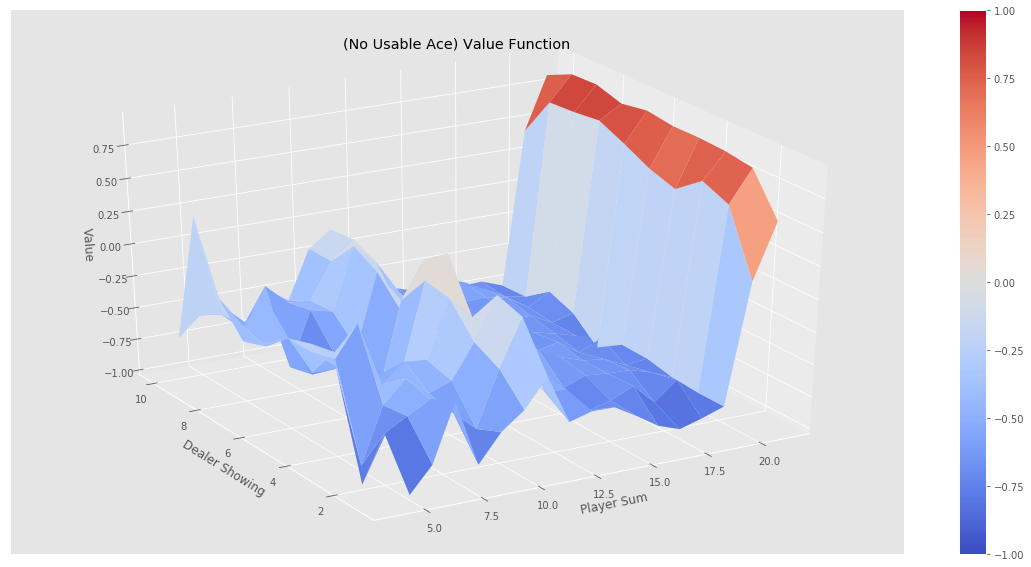

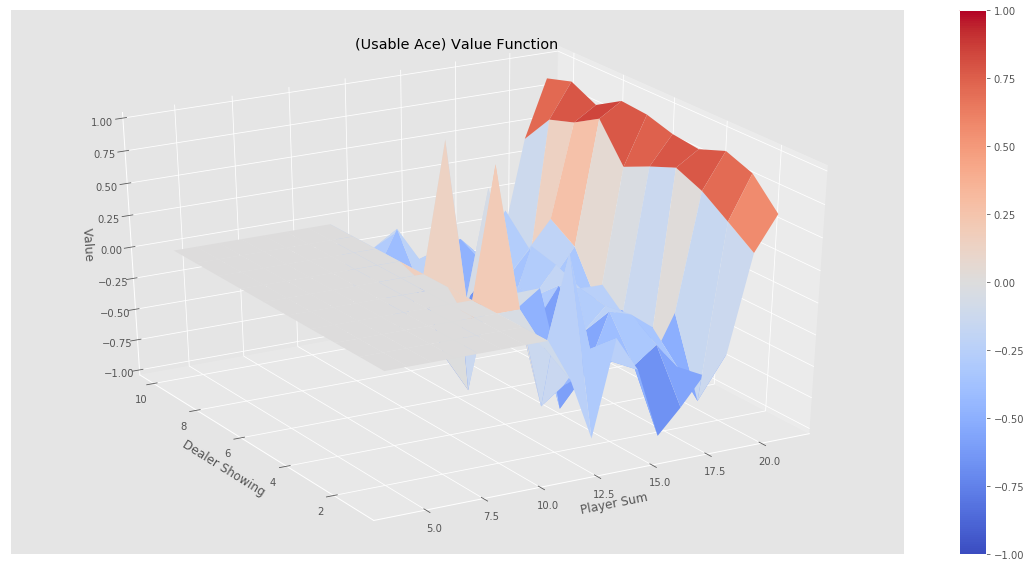

In [7]:
plot_value_function(value_function)

#### With 2M episodes

In [8]:
value_function = mc_prediction(sample_policy,env,num_episodes=2000000)

Episode (200000/2000000)
Episode (400000/2000000)
Episode (600000/2000000)
Episode (800000/2000000)
Episode (1000000/2000000)
Episode (1200000/2000000)
Episode (1400000/2000000)
Episode (1600000/2000000)
Episode (1800000/2000000)
Episode (2000000/2000000)


#### Plot

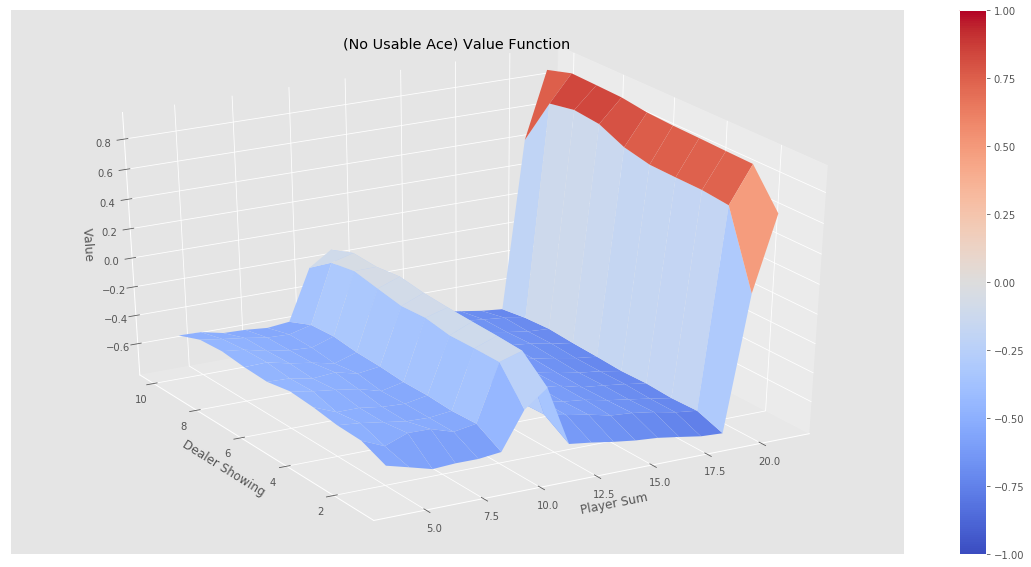

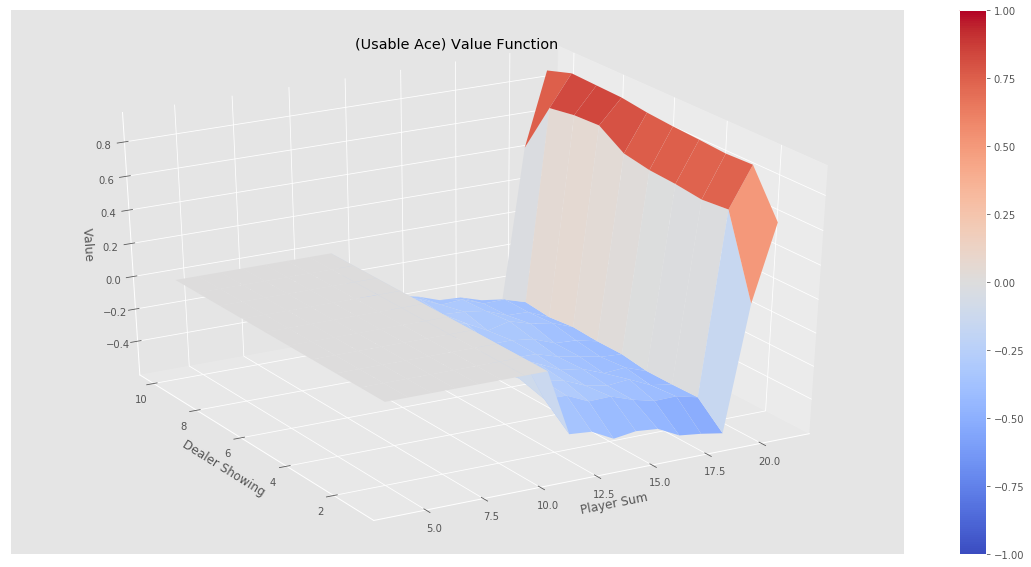

In [9]:
plot_value_function(value_function)

## References

- <a href="http://incompleteideas.net/sutton/book/bookdraft2017june.pdf">Reinforcement Learning: An Introduction</a> - Chapter 5: Monte Carlo Methods